### Load modules

In [1]:
import os 

import pandas as pd
import matplotlib.pyplot as plt

import simtk.unit as unit
from simtk.openmm.app import PDBFile
from simtk.openmm import XmlSerializer
from simtk.openmm.app import Topology
from simtk import openmm

from MDAnalysis.coordinates.DCD import DCDFile

### Setup system from XML file

In [2]:
with open("restrained.xml", "r") as f:
    system = XmlSerializer.deserialize(f.read())
coords = PDBFile("restrained.pdb")

dt   = 4.0 * unit.femtoseconds
Temp = 298.15 * unit.kelvin
Pres = 1.01325 * unit.bar
integrator = openmm.LangevinIntegrator(Temp, 1.0 / unit.picoseconds, dt)
barostat   = openmm.MonteCarloBarostat(Pres, Temp, 100)
system.addForce(barostat)

simulation = openmm.app.Simulation(
    coords.topology, 
    system, 
    integrator,
    openmm.Platform.getPlatformByName('CUDA')
)

### Loop through frames and calculate restraint potential energy

In [3]:
restr_potential = []

with DCDFile(os.path.join("simulations", "npt_production", "trajectory.dcd")) as dcd:
    header = dcd.header

    for frame in dcd.readframes()[0]:
        simulation.context.setPositions(frame * unit.angstrom)
        
        static_restraint_energy = simulation.context.getState(getEnergy=True, groups={10})
        static_restraint_energy = static_restraint_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        conformational_restraint_energy = simulation.context.getState(getEnergy=True, groups={11})
        conformational_restraint_energy = conformational_restraint_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        guest_restraint_energy = simulation.context.getState(getEnergy=True, groups={12})
        guest_restraint_energy = guest_restraint_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        symmetry_restraint_energy = simulation.context.getState(getEnergy=True, groups={13})
        symmetry_restraint_energy = symmetry_restraint_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        wall_restraint_energy = simulation.context.getState(getEnergy=True, groups={14})
        wall_restraint_energy = wall_restraint_energy.getPotentialEnergy() / unit.kilocalorie_per_mole
        
        restr_potential.append([
            static_restraint_energy,
            conformational_restraint_energy,
            guest_restraint_energy,
            symmetry_restraint_energy,
            wall_restraint_energy,
        ])

### Save restraint potential to CSV file

In [4]:
f = open("restraint_potential.csv", "w")
f.writelines(f'"frame","static","conformation","guest","symmetry","wall"\n')
i = 0
for restr in restr_potential:
    f.writelines(f"{i},{restr[0]:.5f},{restr[1]:.5f},{restr[2]:.5f},{restr[3]:.5f},{restr[4]:.5f}\n")
    i += 1
f.close()

### Plot restraint energy

In [5]:
data = pd.read_csv("restraint_potential.csv")
data.head()

,frame,static,conformation,guest,symmetry,wall
0,0,2.92070,0.0,0.0,0.00753,0.0
1,1,3.98953,0.0,0.0,0.00000,0.0
2,2,1.04262,0.0,0.0,0.00000,0.0
3,3,0.39493,0.0,0.0,1.88388,0.0
4,4,3.12023,0.0,0.0,0.16826,0.0


Text(0, 0.5, 'static (kcal/mol)')

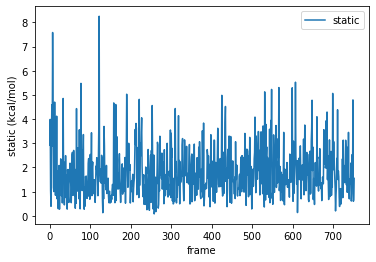

In [6]:
data.plot(x='frame', y='static')
plt.ylabel('static (kcal/mol)')

Text(0, 0.5, 'conformation (kcal/mol)')

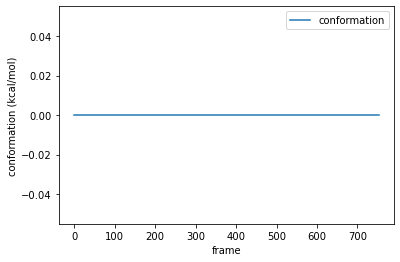

In [7]:
data.plot(x='frame', y='conformation')
plt.ylabel('conformation (kcal/mol)')

Text(0, 0.5, 'guest (kcal/mol)')

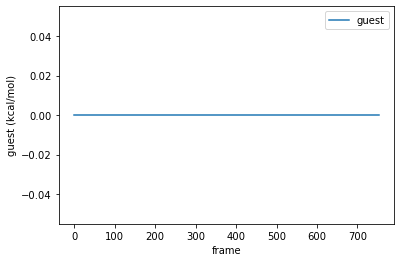

In [8]:
data.plot(x='frame', y='guest')
plt.ylabel('guest (kcal/mol)')

Text(0, 0.5, 'symmetry (kcal/mol)')

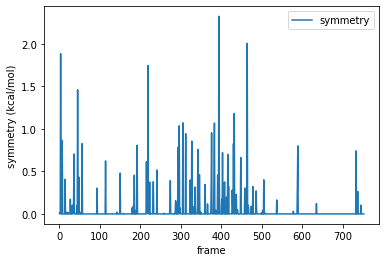

In [9]:
data.plot(x='frame', y='symmetry')
plt.ylabel('symmetry (kcal/mol)')

Text(0, 0.5, 'wall (kcal/mol)')

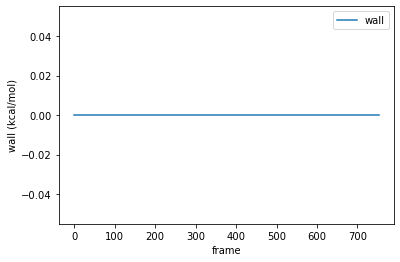

In [10]:
data.plot(x='frame', y='wall')
plt.ylabel('wall (kcal/mol)')